### OBJETIVO: Utilizar um banco de micro dados baseado na Pesquisa de Orçamentos Familiares (POF) de 2017-2018 para calcular o peso social dos domicílios e a característica distributiva de um conjunto de grupos de consumo.

In [1]:
# bibliotecas usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Configurações de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
caminho_arquivo = r"C:\{estudos}\ESP\Economia-do-Setor-Publico-2025.2\Aplicação 3\ESP_2025_aplicação 3_POF 2018-2019.xlsx"
df = pd.read_excel(caminho_arquivo, sheet_name=0)
print(f"Dados carregados: {len(df)} domicílios \n Colunas disponíveis: {df.columns.tolist()}")

Dados carregados: 57920 domicílios 
 Colunas disponíveis: ['ID_DOM', 'PESO', 'NUM_MOR', 'CB', 'OA', 'FUMO', 'BA', 'VE', 'EE_CD', 'AL', 'BS', 'SA', 'TPA', 'TPU', 'COM', 'ED', 'RC', 'HCP', 'OBS']


C:\Users\Madu\AppData\Local\Temp\ipykernel_19264\365826689.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tabela_quintis = df.groupby('QUINTIL', observed=False).apply(media_ponderada).reset_index()



--- RELATÓRIO (i): PESO SOCIAL MÉDIO ---
Média Brasil (Beta médio): 0.014779
  Quintil  Peso Social Médio
0       1           0.041128
1       2           0.018530
2       3           0.011926
3       4           0.007635
4       5           0.003561

--- RELATÓRIO (ii): CARACTERÍSTICA DISTRIBUTIVA DOS GRUPOS ---
   Grupo de Consumo  Característica Distributiva
5             EE_CD                     0.828435
0                CB                     0.742457
2              FUMO                     0.734107
14              HCP                     0.692012
4                VE                     0.611310
6                AL                     0.605204
10              TPU                     0.593012
11              COM                     0.538293
1                OA                     0.514686
13               RC                     0.491583
8                SA                     0.480838
7                BS                     0.468885
12               ED                     0.40910

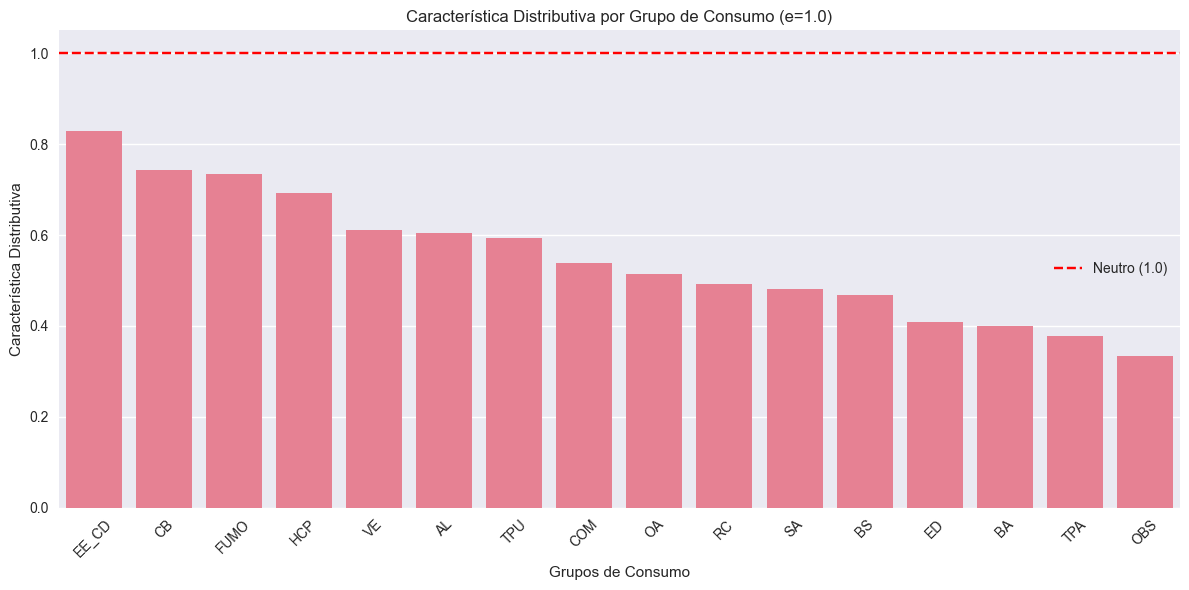

In [3]:
# --- PASSO 2: CÁLCULO DO GASTO DOMICILIAR TOTAL ---
# Lista das variáveis de consumo
cols_consumo = [
    'CB', 'OA', 'FUMO', 'BA', 'VE', 'EE_CD', 'AL', 'BS', 
    'SA', 'TPA', 'TPU', 'COM', 'ED', 'RC', 'HCP', 'OBS'
]

# Soma horizontal das colunas (equivalente ao COMPUTE GASTO = CB + OA + ...)
df['GASTO'] = df[cols_consumo].sum(axis=1)

# --- PASSO 3: CÁLCULO DO GASTO DOMICILIAR TOTAL PER CAPITA ---
# Equivalente ao COMPUTE GASTO_PC = GASTO / NUM_MOR
df['GASTO_PC'] = df['GASTO'] / df['NUM_MOR']

# --- PASSO 4: CÁLCULO DOS PESOS SOCIAIS ---

# 4.1 Identificação do Valor Mínimo
# A sintaxe pede para fixar em 10.29, mas podemos calcular o real para conferência
min_gasto_real = df['GASTO_PC'].min()
y1 = 10.29 # Valor fixado na sintaxe do exercício

# 4.2 a 4.4 Cálculo dos Pesos (Focando em e=1.0 conforme usado no passo 5 da sintaxe)
# Fórmula: (Minimo / Gasto_PC)^(1/e)
e_param = 1.0
df['PESO_SOCIAL_2'] = (y1 / df['GASTO_PC']) ** (1 / e_param)

# --- RELATÓRIO PARTE (i): PESO SOCIAL MÉDIO POR QUINTIL ---
# Para o relatório, precisamos dividir os domicílios em 5 grupos (quintis) de renda/gasto per capita
# e calcular a média ponderada do peso social em cada um.

# Criação dos quintis baseados no Gasto PC ponderado seria o ideal, 
# mas faremos a divisão simples pelos dados amostrais como aproximação padrão ou usar qcut direto
df['QUINTIL'] = pd.qcut(df['GASTO_PC'], 5, labels=[1, 2, 3, 4, 5])

def media_ponderada(x):
    return np.average(x['PESO_SOCIAL_2'], weights=x['PESO'])

# Média geral do Brasil
peso_social_medio_brasil = np.average(df['PESO_SOCIAL_2'], weights=df['PESO'])

# Média por Quintil
tabela_quintis = df.groupby('QUINTIL', observed=False).apply(media_ponderada).reset_index()
tabela_quintis.columns = ['Quintil', 'Peso Social Médio']

print("\n--- RELATÓRIO (i): PESO SOCIAL MÉDIO ---")
print(f"Média Brasil (Beta médio): {peso_social_medio_brasil:.6f}")
print(tabela_quintis)


# --- PASSO 5: CÁLCULO DA CARACTERÍSTICA DISTRIBUTIVA ---

# A Característica Distributiva (CD) é dada por:
# Numerador: Gasto com bem ponderado pelo peso social (e pelo peso amostral)
# Denominador: Gasto com bem ponderado pelo peso social MÉDIO (e pelo peso amostral)

resultados_cd = []

# O valor médio do peso social (beta_medio) já calculamos acima.
# Na sintaxe original era 0.0148. Vamos usar o calculado 'peso_social_medio_brasil' para precisão.

for bem in cols_consumo:
    # 5.1 Numerador: Gasto * Peso Social * Peso Amostral (Soma de tudo)
    # Equivalente a: COMPUTE GASTO_PESO_X = PESO_SOCIAL_2 * X -> SUM(Weight by PESO)
    numerador = (df[bem] * df['PESO_SOCIAL_2'] * df['PESO']).sum()
    
    # 5.3 Denominador: Gasto Total do Bem * Peso Social Médio
    # A sintaxe faz: Média_Beta * Soma_Ponderada_do_Gasto_do_Bem
    gasto_total_bem_ponderado = (df[bem] * df['PESO']).sum()
    denominador = peso_social_medio_brasil * gasto_total_bem_ponderado
    
    # 5.4 Característica Distributiva
    c_dist = numerator = 0
    if denominador != 0:
        c_dist = numerador / denominador
    
    resultados_cd.append({
        'Grupo de Consumo': bem,
        'Característica Distributiva': c_dist
    })

# Criando DataFrame final para o relatório
df_resultados = pd.DataFrame(resultados_cd)

print("\n--- RELATÓRIO (ii): CARACTERÍSTICA DISTRIBUTIVA DOS GRUPOS ---")
# Ordenando para facilitar análise (opcional)
df_resultados_sorted = df_resultados.sort_values(by='Característica Distributiva', ascending=False)
print(df_resultados_sorted)

# --- VISUALIZAÇÃO GRÁFICA (Opcional para enriquecer o relatório) ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_resultados_sorted, 
    x='Grupo de Consumo', 
    y='Característica Distributiva'
)
plt.axhline(1.0, color='red', linestyle='--', label='Neutro (1.0)')
plt.title('Característica Distributiva por Grupo de Consumo (e=1.0)')
plt.ylabel('Característica Distributiva')
plt.xlabel('Grupos de Consumo')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()